In [4]:
# Required for inline figures in ipython notebook
%matplotlib inline

# used for debugging
from __future__ import print_function

import sys
# timing
import time
import numpy as np
import scipy
import scipy.sparse
import scipy.ndimage


# for plotting
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
import matplotlib.pyplot as plt

# image stuff
from skimage import data, io, filters
# from skimage.viewer import ImageViewer

In [23]:
# Utility functions

# Timer
class Timer(object):
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.tstart = time.time()

    def __exit__(self, type, value, traceback):
        if self.name:
            print('[%s] ' % self.name)
        print('Elapsed: %.2f seconds' % (time.time() - self.tstart))

# Debugging
def mydebug(*objs):
    print("**debug: ", *objs, file=sys.stderr)
    
# A 3D plotting function, for showing the kernel we use
def plotkernel(mykernel, ksize):
    fig = plt.figure()
    ax = Axes3D(fig)
    X = np.arange(0, ksize, 1)
    Y = np.arange(0, ksize, 1)
    X, Y = np.meshgrid(X, Y)
    surf = ax.plot_surface(X, Y, mykernel, rstride=1, 
                           cstride=1, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.set_zlim(0, np.max(mykernel))                           
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

In [24]:
def makespdiag(pattern,N):
    """
    This makes a diagonal sparse matrix,similar to a convolution kernel operator

    e.g: 
        makediag([1,2,1],5).todense()

    matrix([[ 2.,  1.,  0.,  0.,  0.],
            [ 1.,  2.,  1.,  0.,  0.],
            [ 0.,  1.,  2.,  1.,  0.],
            [ 0.,  0.,  1.,  2.,  1.],
            [ 0.,  0.,  0.,  1.,  2.]])
    """
    # strangely, all diags may have the same length
    diags=[] # empty list
    for i in pattern :
        diags.append(np.zeros(N) + i)
    n = len(pattern)
    positions = np.arange(-(n/2),(n/2)+1)
    ## print positions
    mat = scipy.sparse.dia_matrix((diags, positions), shape=(N, N))
    return mat

In [33]:
def make_kernel_2D(PSF, dims,debug=False):
    """
        PSF is the 2D kernel
        dims are is the side size of the image in order (r,c) 
    """
    d = len(PSF) ## assmuming square PSF (but not necessarily square image)
    print("kernel dimensions=", dims)
    N = dims[0]*dims[1]
    if debug:
        mydebug("Making kernel with %d diagonals all %d long\n" % (d*d, N))
    ## pre-fill a 2D matrix for the diagonals
    diags = np.zeros((d*d, N))
    offsets = np.zeros(d*d)
    heads = np.zeros(d*d) ## for this a list is OK
    i = 0
    for y in range(len(PSF)):
        for x in range(len(PSF[y])):
            diags[i,:] += PSF[y,x]
            heads[i] = PSF[y,x]
            xdist = d/2 - x 
            ydist = d/2 - y ## y direction pointing down
            offsets[i] = (ydist*dims[1]+xdist)
            i+=1
    ## for debugging
    if debug:
        mydebug("Offsets: ", offsets)
        mydebug("Diagonal heads", heads)
        mydebug("Diagonals", diags) # only useful for small test matrices
    ## create linear operator
    H = scipy.sparse.dia_matrix((diags,offsets),shape=(N,N))
    return(H)

In [34]:
def make_blur_matrix(img, kernel_size=11,debug=True):
    n = kernel_size
    k2 = np.zeros(shape=(n,n))
    k2[n//2,n//2] = 1
    sigma = kernel_size/5.0 ## 2.5 sigma
    testk=scipy.ndimage.gaussian_filter(k2,sigma)  ## already normalized
    if (debug):
        plotkernel(testk,n)  
    blurmat = make_kernel_2D(testk,img.shape)
    return(blurmat)

In [35]:
def deblur_img(blurred_image, blur_matrix, method='spsolve'):
    '''
        Given the blur matrix, this deblurs the input image
    '''
    if (method=='spsolve'):
        deblur = scipy.sparse.linalg.spsolve(blur_matrix.tocsr(),blurred_image.reshape(-1))
    elif (method=='dense'):
        deblur = scipy.linalg.solve(blur_matrix.todense(),blurred_image.reshape(-1))
    else:
        deblur = scipy.sparse.linalg.cg(blur_matrix,blurred_image.reshape(-1))[0]
    return(deblur.reshape(blurred_image.shape)) 

In [36]:
def solve_tykhonov_sparse(y, Degrad, Gamma):
    """
    Tykhonov regularization of an observed signal, given a linear degradation matrix
    and a Gamma regularization matrix. 
    Formula is
    
    x* = (H'H + G'G)^{-1} H'y
    
    With y the observed signal, H the degradation matrix, G the regularization matrix.

    This function is better than dense_tykhonov in the sense that it does
    not attempt to invert the matrix H'H + G'G.
    """
    H1 = Degrad.T.dot(Degrad) # may not be sparse any longer in the general case
    H2 = H1 + Gamma.T.dot(Gamma) # same
    b2 = Degrad.T.dot(y.reshape(-1))
    result = scipy.sparse.linalg.cg(H2,b2)
    return result[0].reshape(y.shape)

In [37]:
def deblur_tikh_sparse(blurred,PSF_matrix,mylambda,method='Id'):
    t1=time.time()
    N = np.prod(blurred.shape)            
    if (method=='Grad'):
        G=makespdiag([0,-1,1],N).toarray()
    elif (method=='Lap'):
        G=make_kernel_2D(np.array([[-1,-1,-1],
                                          [-1,8,-1],
                                          [-1,-1,-1]]),blurred.shape)
    else:
        G=makespdiag([1],N)  ## identity

    elapsed1= time.time()-t1
    t2=time.time()   
    deblurred = solve_tykhonov_sparse(blurred,PSF_matrix,mylambda*G)
    elapsed2=time.time()-t2
    print("Time: %2f s constructing the matrix ; %2f s solving it\n" % (elapsed1,elapsed2))
    return deblurred

In [38]:
def blur_noise_image(given_image, blur_matrix,noise_scale=0.002):
    '''
        This code applies a linear operator in the form of a matrix, similar to
        refblur = scipy.ndimage.convolve(img, testk, mode='constant', cval=0.0)    
    '''
    ## apply blur + noise
    # reshaped to vector
    imgshape=given_image.shape
    N = np.prod(imgshape)
    blurredvect = blur_matrix.dot(given_image.reshape(-1)) + np.random.normal(scale=noise_scale,size=N)
    blurredimg = blurredvect.reshape(imgshape)
    return blurredimg

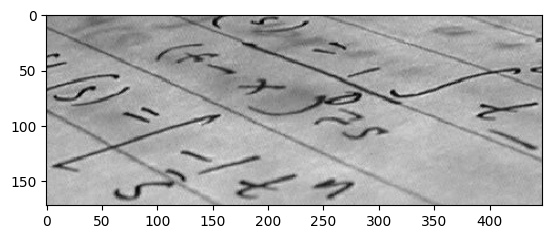

In [43]:
# this image is a simple image of text
imgbig = skimage.data.text()
initplot=plt.imshow(imgbig,cmap='gray')

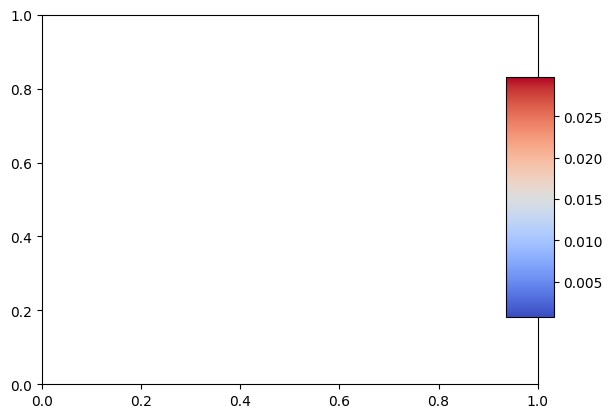

kernel dimensions= (90, 90)


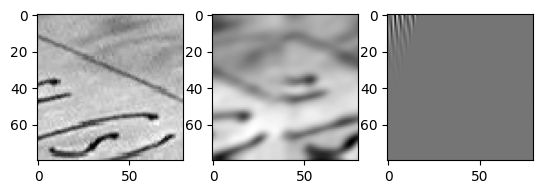

In [42]:
# We reduce the size
tinyimg1 = imgbig[:80,:80]
b = 11 ## blur size
# Pad the image
hb = b//2
tinyimg = np.pad(tinyimg1,hb,'reflect')
tinyblurmat = make_blur_matrix(tinyimg, b,debug=True)
# that is a *minscule* amount of noise
tinyblurredimg = blur_noise_image(tinyimg,tinyblurmat,noise_scale=5e-6)
tinydeblurred = deblur_img(tinyblurredimg, tinyblurmat)
fig,(ax1,ax2,ax3) = plt.subplots(1, 3)
ax1.imshow(tinyimg[hb:-hb,hb:-hb],cmap="gray")
ax2.imshow(tinyblurredimg[hb:-hb,hb:-hb],cmap="gray")
ax3.imshow(tinydeblurred[hb:-hb,hb:-hb],cmap="gray")

kernel dimensions= (138, 138)
kernel dimensions= (138, 138)
Time: 0.000278 s constructing the matrix ; 7.544802 s solving it



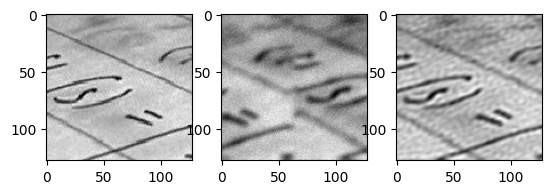

In [52]:
img1 = imgbig[0:128,0:128]
## we use the same blur size as above
img = np.pad(img1,hb,'reflect')
N = np.prod(img.shape)    
blurmat = make_blur_matrix(img, b,debug=False) 
blurredimg = blur_noise_image(img,blurmat,noise_scale=3.0)
fig,(ax1,ax2,ax3) = plt.subplots(1, 3)
ax1.imshow(imgbig[0:128,0:128],cmap='gray')
ax2.imshow(blurredimg[hb:-hb,hb:-hb],cmap="gray")
deblur_tikh = deblur_tikh_sparse(blurredimg, blurmat, 0.025, method='Lap')
ax3.imshow(deblur_tikh[hb:-hb,hb:-hb],cmap="gray")